# Chapter 3. Classification

## MNIST

In this chapter, we will use `MNIST` for classification. `MNIST` is a dataset comprised of `70,000` small images that represent handwritten digits by students & employees from the US census Bureau). Each image is labeled with the digit it represents (ranging from `0` to `9`).

`Scikit-learn` provides many helper functions to download popular datasets:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml(name='mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [20]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [23]:
X, y = X[:35000], y[:35000]
X.shape, y.shape

((35000, 784), (35000,))

In [24]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

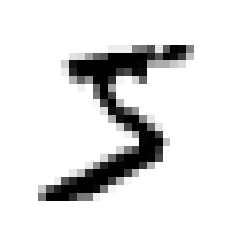

In [25]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [26]:
y[0]

'5'

We note that the label is a string, most algorithms expect numerical inputs so let's transform it:

In [27]:
y = y.astype(np.int8)

But we should always start with splitting the data into train vs. test, right?

In [28]:
X_train, y_train, X_test, y_test = X[:30000], y[:30000], X[30000:], y[30000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30000, 784), (30000,), (5000, 784), (5000,))

Some ML algorithms are sensitive to ordered rows and can perform badly if instances from the same class are grouped together, the solution to this is to shuffle.

`MNIST`'s training data is already shuffled for us.

## Training a Binary Classifier

Let's simplify the problem for now and try to identify one digit (number **5**). This "5-detector" is an example of a binary classifier, it will predict, for any row, 5 or not-5.

Let's create the target vector for the classification task:

Let's take a fraction of the training data for the notebook to run fast locally:

In [29]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

A good place to start is with a Stochastic Gradient Descent Classifier:

In [30]:
from sklearn.linear_model import SGDClassifier

In [31]:
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

In [32]:
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now we will use it to predict the digit of image at index 0:

In [33]:
sgd_clf.predict(X=[some_digit])

array([ True])

.. and it's indeed a 5.

Now let's evaluate this model's performance:

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. sThere are many performance measures available.

### Measuring Accuracy using Cross Validation

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [35]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

In [36]:
for train_index, test_index in skfolds.split(X=X_train, y=y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct / len(y_pred))

0.9458
0.9634
0.9603


Alternatively, let's use `cross_val_score()` function to do Kfold cross validation where $K=3$:

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
scores = cross_val_score(estimator=clone(sgd_clf), X=X_train, y=y_train_5, cv=5, scoring="accuracy", n_jobs=-1)
scores

array([0.95784036, 0.973     , 0.9585    , 0.97266667, 0.94649108])

Above $95\%$ accuracy, isn't that great?

Let's look at the performance of a very dumb classifier that classifies all training rows as "Not-5":

In [39]:
from sklearn.base import BaseEstimator

In [40]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(shape=(len(X), 1), dtype=bool)

In [41]:
never_5_classifier = Never5Classifier()

In [42]:
scores = cross_val_score(estimator=never_5_classifier, X=X_train, y=y_train_5, cv=5, scoring="accuracy", n_jobs=-1)
scores

array([0.91433333, 0.911     , 0.91016667, 0.90716667, 0.90583333])

The dumb classifier has over 90% acccuracy for any validation. This happened because of the class imabalance in the binary task we are aiming for.
    
We originally had balanced counts for each digit. But when we turned the problem into `5 vs. non-5`, we ended up with the first class taking `~10%` of the rows and non-5 taking `>=90%`. Hence, if we create a dumb model that just predicts "non-5" for any input, you'll get at least 90% accuracy.

This demonstrates why accuracy is generally not the preferred method to evaluate classifiers, especially if the data have imbalanced classes.

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at its produced confusion matrix.

Let's use `cross_val_predict()` to get some predictions to finally visualize the confusion matrix:

In [43]:
from sklearn.model_selection import cross_val_predict

In [44]:
y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, n_jobs=-1)

In [45]:
y_train_pred.shape

(30000,)

`corss_val_predict` returns the predictions made of the test fold and because we are looping over the 3 folds, we endup with predictions for all data.

Let's take a look at the confusion matrix:

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_pred)

array([[26515,   776],
       [  529,  2180]])

Each row in the confusion matrix represents an actual class. While each column represents a predicted class.

- first row is "not 5": Model correctly predicted "not 5" for 26K "not 5"s (True Negatives).
- Model incorrectly predicted "5" for 776 "not 5"s (False Positives).
- second row is "5": Model incorrectly predicted "not 5" for 529 "5"s (False Negative)
- Model correctly predicted "5" for 2180 "5"s (True Positives)

A perfect classifier would have only True Positives and True negatives, meaning the confusion matrix will have zeros on all elements except its diagonal.

Let's pretend we reached perfection:

In [48]:
y_train_perfect_predictions = y_train_5.copy()

In [49]:
confusion_matrix(y_true=y_train_5, y_pred=y_train_perfect_predictions)

array([[27291,     0],
       [    0,  2709]])

The confusion matrix gives us a lot of information, but sometimes you may prefer a single-number metric. 

An interesting one to look at is the model's accuracy over its positive predictions, named *precision*:

$$precision = \frac{TP}{TP+FP}$$

A trivial way to have a perfect precision of $1$ is to make one prediction that you're sure it's correct, by consequence $FP=0$ and $precision=1$. This would not be useful since the evaluation is ignore all but the true positives.

Precision is typically used along with another metric named recall. 

Recall, also called sensitivity or the True Positive rate is as follows:

$$recall = \frac{TP}{TP+FN}$$

### Precision & Recal

In [50]:
from sklearn.metrics import precision_score, recall_score

In [51]:
precision_score(y_true=y_train_5, y_pred=y_train_pred)

0.7374830852503383

In [52]:
recall_score(y_true=y_train_5, y_pred=y_train_pred)

0.8047249907715024

The recall score is not good at all.

Its dominator consists of TPs & **False Negatives**. We can conclude that our model is predicting a lot of digits as not "5" but they're "5"s. The model is not good at predicting False Negatives.

Now our model doesn't look as shiny as it was when we looked at its accuracy. When it claims that a digit represents a "5" it's only correct for $80\%$ of the times.

It's often convinient to combine the precision and accuracy scores into a single metric called the $F_{1}$ score. In particular, if we want to compare two classifiers.

The $F_{1}$ score represents the harmonic mean of the precision & recall metrics. It is harmonic because it gives more importance to low values in its formula. 

Meaning, the F1 score will only give you high scores if both precision and recall are high.

$$F_{1}=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2 \times \frac{precision \times recall}{precision + recall}$$

In [53]:
from sklearn.metrics import f1_score

In [54]:
f1_score(y_true=y_train_5, y_pred=y_train_pred)

0.7696381288614299

The $F_{1}$ favors classifiers that have similar precision and recall. But this is not always what we would want:

Sometimes we only care about precision (the relation between True Positives and **False Positives**). Ex: we don't want to incorrectly predict that a bad video is safe for kids to watch, but you don't care that much if you incorrectly predict that a video is bad.

Other times we only care about recall (the relation between True Positives and **False Negatives**). Ex: we don't want to incorrectly predict that a person doesn't have cancer.

Unfortunately, we can't have it both ways, increasing precision will decrease recall, and increasing recall decreases precision.

This is called the precision-recall trade-off.

### Precision-Recall Trade-off

To understand this trade-off, we need to know how the algorithm is making its decisions.

For each instance, the classifier outputs a score (we can call it a probability), if the score is higher than a certain threshold, we label the instance as positive (a "5"), but if the score is less than the threshold, we the instance as negative (a "not 5")

<div style="text-align:center"><img style="width: 50%" src="static/imgs/precision-recall-trade.png" /></div>

As we can see, if we raise the threshold, precision converges to $100%$, but as a result, we lower the recall. Same happens to recall if we lower the threshold, we get a better recall (False Negatives are fewer) but we decrease precision.

`Scikit-learn` doesn't allow us to set the threshold directly, but it can give us the scores for each of its prediction.

We can set the threshold we want after getting the scores:

In [55]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([11968.30313346])

In [56]:
threshold = 0

In [57]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Let's raise the threshold:

In [58]:
threshold = 8000

In [59]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

How do we decide which threshold to use?

In [60]:
y_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, 
                             cv=3, method='decision_function', n_jobs=-1)

With these decision scores, we use another function to compute the recalls/precisions for all possible threshold:

In [61]:
from sklearn.metrics import precision_recall_curve

In [62]:
precision, recall, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

Finally, we use `matplotlib` to plot precision and recall in function of the threshold value:

In [63]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.grid()

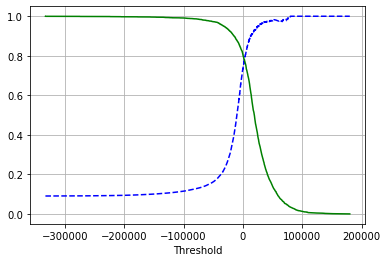

In [64]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

We may wonder why the precision curve is bumpier than the recall curve. The reason is that the precision may sometimes go down when we raise the threshold. We may lose precision by upping the threshold if we lose TPs while the FPs are still there, but generally, precision should increase.

On the other hand, recall is very smooth because we add another TN while moving the threshold, nothing changes in the score.

Another way to select a good precision and recall trade-off is to plot precision directly against recall:

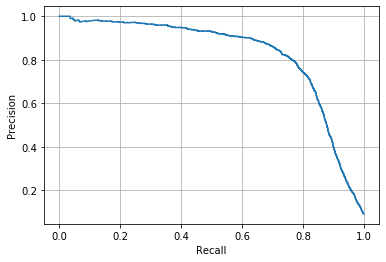

In [65]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

We can see the precision really starts to fall sharply around 80% recall.

We would probably want to select a precision/recall trade-off just before **that drop** (For example, at around $60\%$ recall). But ofcoures, the choice depends on the project.

Suppose we want to aim for $90\%$ precision, we would look up the first graph to get the threshold and lookup the second graph to find the best Recall we can get with a precision of $90\%$.

Implementation: let's search for the lowest threshold that give at least $90\%$ precision score:

In [66]:
threshold_90_precision = thresholds[np.argmax(precision > .9)]
threshold_90_precision

12605.39256572511

To make predictions for the training set, you first get the score of the desired point and compare the score to the chosen threshold:

In [67]:
y_train_pred_90 = (y_scores > threshold_90_precision)

Let's check these predictions' precision and recall:

In [68]:
precision = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
precision

0.9003181336161188

In [69]:
recall = recall_score(y_train_5, y_train_pred_90)
recall

0.6267995570321152

We should remember that a high precision classifier is not good at all with a low recall.

If someone shouts: "Let's reach a 99% precision score", you should ask: "But at what Recall?"

### The ROC Curve

The receiver operating characteristic curve is another tool used with binary classifiers. ROC plots TP rate versus FP rate.

ROC plots recall versus 1 - specificity

In [70]:
from sklearn.metrics import roc_curve

In [71]:
fpr, tpr, thresholds = roc_curve(y_true=y_train_5, y_score=y_scores)

In [72]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--', label='Random')
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

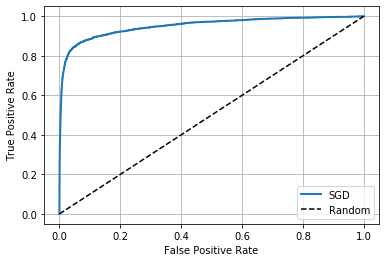

In [73]:
plot_roc_curve(fpr, tpr, label='SGD')
plt.legend(loc='lower right')
plt.show()

The Higher the recall, the more false positives the model produces.

The dotted line represent the ROC curve of a completely random classifier. A good classifier stays as far a way as possible from the dotted line.

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have an ROC AUC of 1 and a purely random classifier will have an ROC AUC of 0.5.

Example:

In [74]:
from sklearn.metrics import roc_auc_score

In [75]:
roc_auc_score(y_train_5, y_scores)

0.9509867800410808

Let's now train a `RandomForestClassifier` to compare its ROC Curve and ROC AUC score to the `SGDClassifier`'s:

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
forest_clf = RandomForestClassifier(random_state=42)

In [78]:
y_probas_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                    y=y_train_5, cv=5, 
                                    n_jobs=-1, method='predict_proba')

In [79]:
y_scores_forest = y_probas_forest[:, 1]  # P(X=5)

In [80]:
fpr_forest, tps_forest, threshs_forest = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

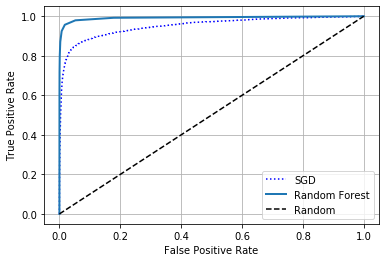

In [81]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tps_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

We can see that `Random Forest classifier` is superior to `SGD` because its curve is much closer to the top left corner of the graph.

Let's check its area under the curve (AUC):

In [82]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921782134037131

Let's measure the precision & recall for `RF`:

In [83]:
y_preds_forest = cross_val_predict(estimator=forest_clf, X=X_train, 
                                   y=y_train_5, cv=5, 
                                   n_jobs=-1)

In [84]:
precision_score(y_true=y_train_5, y_pred=y_preds_forest)

0.9859026830377444

In [85]:
recall_score(y_true=y_train_5, y_pred=y_preds_forest)

0.8002953119232189

We now know how to ...
- train classifiers
- choose the appropriate metric for the task
- evaluate the classifier using cross-validation
- select the precision-recall ratio that fits the needs
- use ROC and ROC AUC to compare various models

Time to move to multiclass classification (beyond binary classification):

## Multiclass Classification

There are techniques we can use to perform multiclass classification with binary classifiers. One way to create a system that can classify an image into 10 labels (from 0 to 9) is to train 10 binary classifiers (one for each digit). 

Then when we want to classify an image, we get each classifier's associated positive score and pick the model class w/ the highest score. This is called one-versus-the-rest startegy, or 1-vs-all.

Another startegy is to train a binary classifier for each pair of digits. This is called 1-vs-1. If there are $N$ classes, we would need to train $\frac{N \times (N-1)}{2}$. For the MNIST Problem, this means training $45$ binary classifiers. The class which wins the most duals is the predicted one.

Even though we need to create many classifiers, they are needed to be trained on only the data points where one of the classes appeared.

`Scikit-learn` detects when we try to use a binary classification algorithm for a multiclass classification problem, it then automatically use OvO or OvR depending on the algorithm to train.

In [86]:
from sklearn.svm import LinearSVC

In [87]:
svm_clf = LinearSVC()

In [88]:
X_train.shape, y_train.shape

((30000, 784), (30000,))

Note: Support Vector Machines trained with non-linear kernels has a compexity of `O(n_samples^2 * m_features)`.

That is why we are training `LinearSVC` instead of `SVC`:

In [89]:
svm_clf.fit(X=X_train, y=y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [90]:
svm_clf.predict([some_digit])

array([3], dtype=int8)

In this case, the Support Vector Classifier used `OvO` to predict the class of `some_digit`. It tried $N*(N-1)/2$ classifier for all pairs of classes.

After inputing a new sample, it runs all `45` trained models and picks the one who won the most duals.

If we inspect the score for a specific instance input, we will notice that the model outputs 10 scores, for each digit. Giving us a performance measure of each digit versus all others. 

In [91]:
some_digit_scores = svm_clf.decision_function(X=[some_digit])
some_digit_scores

array([[-2.07249823, -9.07709945, -1.73230222,  0.72046274, -5.12401579,
         0.19933341, -5.44531551, -5.64787969, -3.6019937 , -3.92171732]])

In [92]:
np.argmax(some_digit_scores)

3

In [93]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [94]:
svm_clf.classes_[np.argmax(some_digit_scores)]

3

If we want to force the algorithms to follow a particular startegy, `OvO` or `OvR` for example:

In [95]:
from sklearn.multiclass import OneVsRestClassifier

In [96]:
ovr_clf = OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

In [97]:
ovr_clf.fit(X=X_train, y=y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=-1)

In [98]:
ovr_clf.predict([some_digit])

array([3], dtype=int8)

In [99]:
len(ovr_clf.estimators_)

10

SGD or Random Forest Classifiers can directly classify an instance into multiple classes:

In [100]:
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

In [101]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [102]:
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [103]:
sgd_clf.decision_function([some_digit])

array([[ -50458.5075631 , -136486.63842062,  -14135.49961456,
         -10399.0572803 ,  -63068.57630296,   -3043.28005489,
         -64103.92249307,  -68757.6494235 ,  -44670.30230201,
         -27252.81246434]])

Let's evaluate the performance of our classifiers using cross-validation:

In [104]:
cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=5, scoring='accuracy', n_jobs=-1)

array([0.87824783, 0.82422526, 0.85585736, 0.88610972, 0.86140761])

It gets over 84% over all test folds.

If we use a random classifier, we would get 10% accuracy, so 80% isn't that bad. However, by simply scaling the input we can push accuracy to over 86%:

In [105]:
from sklearn.preprocessing import StandardScaler

In [106]:
scaler = StandardScaler()

In [107]:
X_train_scaled = scaler.fit_transform(X=X_train.astype(np.float64))

In [108]:
cross_val_score(estimator=sgd_clf, X=X_train_scaled, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)

array([0.90739507, 0.90503166, 0.89218464, 0.90628648, 0.90226818])

## Error Analysis

If this was a real machine learning project, we would need to follow the steps in the checklist:
- Explore data preparation options.
- Try out, shortlisting, & hyper-parameter finetuning multiple models.
- Automate as much as possible.

Here, we will assume that we have found a promissing model and that we want to improve it. One of the few ways is to analyze the types of errors it makes.

First, let's look at the confusion matrix:

In [109]:
y_train_predict = cross_val_predict(estimator=sgd_clf, X=X_train_scaled, y=y_train, cv=5, n_jobs=-1)

In [110]:
conf_mtrx = confusion_matrix(y_true=y_train, y_pred=y_train_predict)
conf_mtrx

array([[2806,    0,   15,    4,    4,   29,   17,    2,   84,    0],
       [   1, 3249,   26,   14,    3,   24,    3,    3,   93,    7],
       [  14,   17, 2587,   57,   38,   14,   38,   21,  156,    6],
       [  13,   15,   72, 2651,    2,   95,   11,   27,  150,   37],
       [   9,    8,   27,    7, 2623,    4,   20,   10,  120,   98],
       [  16,   11,   19,   82,   39, 2253,   37,    7,  204,   41],
       [  16,    6,   22,    0,   22,   46, 2801,    5,   57,    0],
       [  11,    3,   36,   16,   28,    2,    3, 2821,   53,  134],
       [   6,   35,   23,   58,    3,   55,   23,    3, 2648,   21],
       [  16,   13,   17,   31,   61,   15,    1,   86,  123, 2640]])

- It's often better to look at an image representation of the confusion matrix:

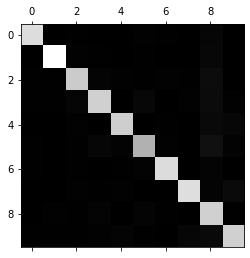

In [111]:
plt.matshow(A=conf_mtrx, cmap=plt.cm.gray)
plt.show()

Let's focus the plot on the errors. Instead of plotting the absolute numbers, we will plot counts over the number of images of the class:

In [112]:
row_sums = conf_mtrx.sum(axis=1, keepdims=True)

In [113]:
normed_conf_mtrx = conf_mtrx / row_sums

Then we fill the diagonal with zeros to highlight only the errors:

In [114]:
np.fill_diagonal(normed_conf_mtrx, val=0)

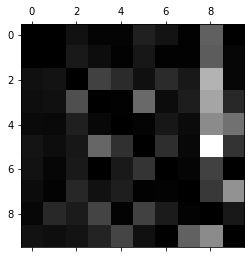

In [115]:
plt.matshow(A=normed_conf_mtrx, cmap=plt.cm.gray)
plt.show()

We can clearly see the kind of errors the classifier makes. Remember that the rows represent acutal labels and the columns represent the predicted class.

The column of class `8` is quite bright, which tells us that many input images get misclassified as `8`s. However, the row for 8s is not that bad, telling us that when given input images of 8s, the model does a good job of classifying them as 8s.

As we can see, the confusion matrix is not necessarly symmetrical. In our specific example, `3`s and `5`s are often confused.

Analyzing the confusion matrix often gives us insights into how to improve the classifier itself.

Looking at this plot, it seems that our efforts should be focused on reducing the false 8s. For example, we could try collecting images of digits that look like 8s but are not, then training the classifier to better distinguish.

Analyzing our errors could be also a good way into knowing what the model is learning and why is it failling.

In [116]:
cl_a, cl_b = 3, 5 

In [117]:
X_aa = X_train[(y_train == cl_a) & (y_train_predict == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_predict == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_predict == cl_b)]

In [118]:
from math import ceil

In [119]:
def plot_digits(instances, images_per_row=10, **options):
    """Plots digits on a grid of rows and columns
    
    # Arguments
        instances: np.ndarray, the digits, where each is a flat array
        images_per_row: int, how many digits to be displayed per row
        options: other arguments for `plt.imshow()`
    """
    size = 28
    n_images = instances.shape[0]
    images_per_row = min(images_per_row, n_images)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = ceil(n_images / images_per_row)
    row_images = list()
    n_empty = (n_rows * images_per_row) - n_images
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap='binary', **options)
    plt.axis('off')

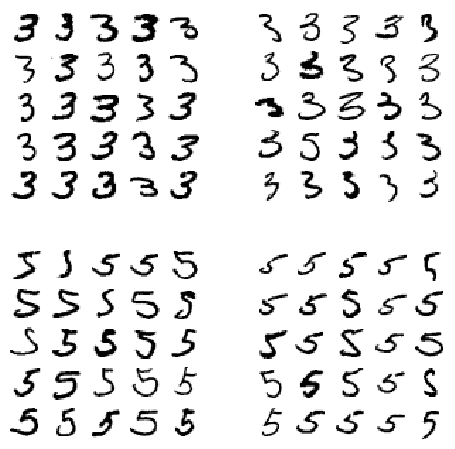

In [120]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two `5x5` blocks on the left show instances classified as `3`s, and the two `5x5` blocks on the right show instances classified as `5`s.

Most misclassifed images seem like obvious mistakes to us and it's hard for us to understand why the classifier made the mistakes it did.

The true reason is that when we used `SGDClassifier`, which is a linear model, it just assigns weights to each pixel, and when it gets a new image, it sums up the pixel intensities times the trained weights, and since 5s and 3s share most of the pixel intensity locations, the model get sometimes confused.

The main difference between a `5` and a `3` is the position of the small line that joins the top line to the bottom arc.

Meaning that if we draw a 3 with a slightly shifted line to the left, the classifier might assign it a 5, and same to 5s classified as 3s.

In other words, this classifier is quite sensitive to image rotation and shifting. **So one way to reduce errors is to preprocess the images to make sure the digits are well centered and not too rotated**.

## Multilabel Classification

In some cases, we want our classifier to output multiple classes per instance (e.g. Face recognition in images). 

What should it do when it recognizes several people in a picture?

Such system that outputs multiple binary scores that don't necessarly sum up to 1 is called a multilabel classifier.

Let's go through a simple example:

In [121]:
from sklearn.neighbors import KNeighborsClassifier

In [122]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

In [123]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [124]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [125]:
knn_clf.fit(X=X_train, y=y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Now we can make a prediction, and notice it outputs multiple labels:

In [126]:
knn_clf.predict(X=[some_digit])

array([[False,  True]])

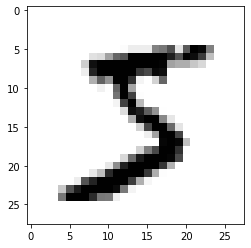

In [127]:
plt.imshow(some_digit.reshape(28, 28), cmap='binary')

Got it right! 5 is indeed less than 7 and odd.

There are many ways to evaluate a multilabel classifier, selecting the best metrics will depend on the project. One approach is to simply calculate $F_1$ score for each label category, then average all scores into one number:

In [128]:
from sklearn.metrics import f1_score

In [129]:
y_train_knn_pred = cross_val_predict(estimator=knn_clf, X=X_train, y=y_multilabel, cv=5, n_jobs=-1)

In [130]:
score = f1_score(y_multilabel, y_train_knn_pred, average="macro")
score

0.9720267778020544

This assumes that all label categories are equally important, which may not be true. In particular, if we have more pictures of alice than bob we may want to give more weight to bob pics in evaluation. This is called unbalanced classes within a label category.

One simple way to do it is to give each class a score corresponding to it support. The less samples we have of bob, the more important one score of him is.

## Multioutput Classification

The last type of classification we will discuss is called multioutput-multiclass classification (Ex. Identifying animals in a picture & for each animal we have N classes). Meaning, each label can be multiclass.

To demonstrate this, let's build a system that removes noise from images. It will take the noisy digit images as input, and will hopefully output an image that look like the original one from the dataset. Notice that the system is a multioutput classification one (Output: 728 pixels, each pixel intensity ranges from 0 to 255).

Let's start with training data by adding a mask of noise, the original image will serve as the output (target):

In [131]:
noise = np.random.randint(low=0, high=100, size=(X_train.shape[0], 784))

In [132]:
X_train_mod = X_train + noise
X_train_mod.shape

(30000, 784)

In [133]:
noise = np.random.randint(low=0, high=100, size=(X_test.shape[0], 784))

In [134]:
X_test_mod = X_test + noise
X_test_mod.shape

(5000, 784)

In [135]:
y_train_mod = X_train.copy()
y_test_mod = X_test.copy()

Let's take a look at an X -> Y from the training set:

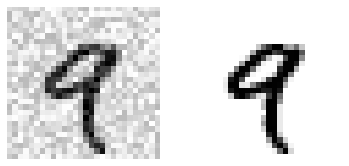

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[0].axis('off')
ax[1].imshow(y_train_mod[4:5].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

Now let's train the classifier to clean this image:

In [137]:
knn_clf.fit(X=X_train_mod, y=y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [138]:
clean_digit = knn_clf.predict(X=[X_test_mod[234]]).reshape(28, 28)

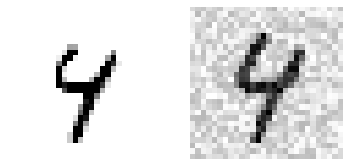

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(clean_digit, cmap='binary'); ax[0].axis('off')
ax[1].imshow(X_test_mod[234].reshape(28, 28), cmap='binary'); ax[1].axis('off')
plt.show()

Looks close enough to the target.

With this, we finish our classification chapter.

---

# Exercices

**1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy over the test set.**

`KNeighbors` classifier works well for this task.

We just need to find good hyperparameter values. We'll try a grid search on `weights` and `n_neighbors` 

In [51]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style()
from sklearn.datasets import openml

In [52]:
mnist = openml.fetch_openml(name='mnist_784', version=1)

In [53]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

In [54]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [6]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
scores = cross_val_score(estimator=knn_clf, X=X_train, y=y_train, scoring='accuracy', cv=5, n_jobs=-1)

In [9]:
scores

array([0.9697626 , 0.97017164, 0.96941667, 0.96815871, 0.96898966])

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3, 4, 5]
}

In [12]:
grid_search_clf = GridSearchCV(estimator=knn_clf, param_grid=grid, scoring='accuracy', cv=5, verbose=3, n_jobs=-1)

In [13]:
grid_search_clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 63.4min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 63.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [14]:
grid_search_clf.best_score_

0.9716166666666667

In [15]:
grid_search_clf.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

Let's train the model with the best parameters over the whole training set (without cross validation):

In [6]:
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)

In [7]:
knn_classifier.fit(X=X_train, y=y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

Now we'll evaluated our model over the test set:

In [8]:
knn_classifier.score(X=X_test, y=y_test)

0.9714

We got $97.14\%$ accuracy! Finally, Let's save the model:

In [20]:
from joblib import dump

In [21]:
dump(knn_classifier, 'models/02/knn_MNIST_97.joblib')

['models/02/knn_MNIST_97.joblib']

**2. Write a function that can shift an MNIST image in any direction**

We want to Left/Right/Up/Down by 1 pixel. Then for each image in the training set, create 4 shifted copies and add the copies to the training set. Finally, train the model on this training set and evaluate it on the test set.

This technique of expanding the training set is commonly referred to as *Data Augmentation* or *Training set expansion*

In [56]:
from scipy.ndimage.interpolation import shift
from sklearn.metrics import accuracy_score

In [57]:
def shift_digit(imgs, direction):
    """Shifts image by 1 pixel in any direction
    
    # Arguments
        imgs: np.ndarray, contains flattened digit images
        direction: string, direction you want to shift the pixels in. \in {'left', 'right', 'up', 'down'}
    
    # Returns
        shifted: np.ndarray, the resulting shifted image
    """
    dir_to_shift = {
        'up': [0, -1, 0],
        'down': [0, 1, 0],
        'left': [0, 0, -1],
        'right': [0, 0, 1]
    }
    return shift(imgs.reshape(-1, 28, 28), shift=dir_to_shift[direction], cval=0).reshape(-1, 28*28)

Now let's create 4 images for each image present in the training dataset:

In [58]:
up_shifted_X_train = shift_digit(X_train, 'up')
down_shifted_X_train = shift_digit(X_train, 'down')
left_shifted_X_train = shift_digit(X_train, 'left')
right_shifted_X_train = shift_digit(X_train, 'right')

In [59]:
aug_X_train = np.concatenate((up_shifted_X_train, down_shifted_X_train, left_shifted_X_train, right_shifted_X_train), axis=0)
aug_X_train.shape

(240000, 784)

In [60]:
aug_y_train = np.concatenate((y_train, y_train, y_train, y_train), axis=0)
aug_y_train.shape

(240000,)

Add in shuffling by index:

In [61]:
import random

In [62]:
def shuffle_X_y(X, y):
    """Shuffles two arrays using indexes
    
    # Arguments
        X: np.ndarray, input
        y: np.ndarray, output
    
    # Returns
        shuffled_X: np.ndarray
        shuffled_y: np.ndarray
    """
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    return X[indices], y[indices]

Now we add the augmented imagery to `X_train` & `y_train`:

In [63]:
X_train.shape, aug_X_train.shape, y_train.shape, aug_y_train.shape

((60000, 784), (240000, 784), (60000,), (240000,))

In [64]:
X_train = np.concatenate((X_train, aug_X_train), axis=0)
y_train = np.concatenate((y_train, aug_y_train), axis=0)

In [65]:
X_train.shape, y_train.shape

((300000, 784), (300000,))

In [66]:
X_train, y_train = shuffle_X_y(X_train, y_train)

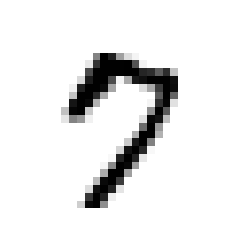

In [72]:
plt.imshow(X_train[99].reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()

In [73]:
y_train[99]

'7'

Finally, we train our classifier with the best hyper-parameters we found:

In [74]:
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance', n_jobs=-1)

In [75]:
knn_classifier.fit(X=X_train, y=y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

Now we evaluate our model over the test set:

In [76]:
y_hat = knn_classifier.predict(X=X_test)
accuracy_score(y_true=y_test, y_pred=y_hat)

0.9763

We got $97.63\%$ test accuracy, $+0.5\%$ more than $97.14\%$ by using data augmentation!

---